In [1]:
# !pip install mediapipe

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import os

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    # mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    # mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

In [6]:
cap = cv2.VideoCapture('./Core/Individual/1.mp4')

sequences = []

with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        image, results = mediapipe_detection(frame, holistic)
        
        draw_landmarks(image, results)
        
        pose = extract_keypoints(results)
        sequences.append(pose)
        
        cv2.imshow('Open CV Feed', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    
    cap.release()
    cv2.destroyAllWindows()

In [7]:
len(sequences)

96

## Body Activation ##

In [8]:
body_activations = np.array(['Total Body', 'Lower Body', 'Upper Body', 'Core'])
no_sequences = 100
sequence_length = 120

In [9]:
for body in body_activations:
    data_path = './'+body+'/Individual/'
    for num in range(1,no_sequences+1):
        try:
            os.makedirs(os.path.join('./Numpy Data', body, str(num)))
        except:
            pass


In [10]:
# ## Finish Setting up collections of data points and classification labels and AI

# for body in body_activations:
#     data_path = './'+body+'/Individual/'
#     for num in range(1,no_sequences+1):
#         print(data_path+str(num)+'.mp4')
#         cap = cv2.VideoCapture(data_path+str(num)+'.mp4')
#         i = 0


#         with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as holistic:
#             while cap.isOpened():
#                 ret, frame = cap.read()
#                 if not ret:
#                     break

#                 image, results = mediapipe_detection(frame, holistic)

#                 draw_landmarks(image, results)
                
#                 if num == 1:
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Colecting frames for {}, Video Number {}'.format(body, num), (15, 12), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 255), 1, cv2.LINE_AA)
#                 else:
#                     cv2.putText(image, 'Colecting frames for {}, Video Number {}'.format(body, num), (15, 12), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 255), 1, cv2.LINE_AA)

#                 cv2.imshow('Open CV Feed', image)
                
#                 pose = extract_keypoints(results)
#                 npy_path = os.path.join('./Numpy Data', body, str(num), str(i))
#                 np.save(npy_path, pose)
#                 i += 1
                

#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break


#             cap.release()
#             cv2.destroyAllWindows()

## Preprocess Data and Create Labels ##

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(body_activations)}

In [13]:
label_map

{'Total Body': 0, 'Lower Body': 1, 'Upper Body': 2, 'Core': 3}

In [14]:
sequences, labels = [], []
for body in body_activations:
    print('Appending {}'.format(body))
    for sequence in range(1, no_sequences+1):
        window =[]
        for frame_num in range(sequence_length):
            res = np.load(os.path.join('./Numpy Data', body, str(sequence), '{}.npy'.format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[body])

Appending Total Body
Appending Lower Body
Appending Upper Body
Appending Core


In [15]:
np.array(sequences).shape, np.array(labels).shape

((400, 120, 132), (400,))

In [16]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [17]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size = 0.1, shuffle = True)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((360, 120, 132), (40, 120, 132), (360, 4), (40, 4))

In [20]:
type(y_train)

numpy.ndarray

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [22]:
log_dir = os.path.join('Logs')
tb_callbacks = TensorBoard(log_dir = log_dir)

In [23]:
model = Sequential()
model.add(GRU(32, return_sequences = True, activation = 'relu', input_shape = (120, 132)))
model.add(GRU(64, return_sequences = True, activation = 'relu'))
model.add(GRU(128, return_sequences = False, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 120, 32)           15936     
_________________________________________________________________
gru_1 (GRU)                  (None, 120, 64)           18816     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               74496     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 134,276
Trainable params: 134,276
Non-trainable params: 0
__________________________________________________

In [25]:
model.compile(optimizer = Adam(learning_rate=1e-5), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['categorical_accuracy'])

In [33]:
# model.fit(X_train, y_train, batch_size = 64, epochs = 1000)

In [34]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 0.0487 - categorical_accuracy: 1.0000


[0.0486975833773613, 1.0]

In [35]:
res = model.predict(X_test)

In [38]:
body_activations[np.argmax(res[1])]

'Core'

In [39]:
body_activations[np.argmax(y_test[1])]

'Core'

In [28]:
# model.save('actions.h5')
model.load_weights('actions.h5')

## Confusion matrix and Accuracy ##

In [29]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
y_hat = model.predict(X_test)
y_true = np.argmax(y_test, axis = 1).tolist()
y_hat = np.argmax(y_hat, axis = 1).tolist()

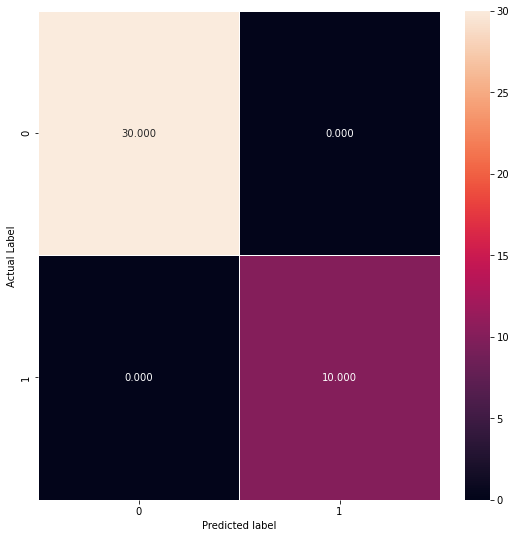

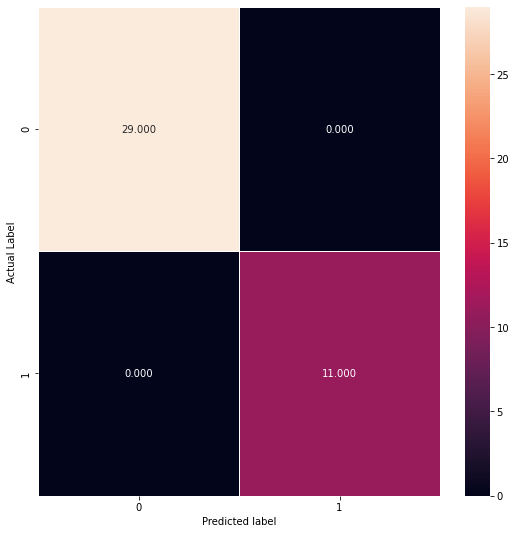

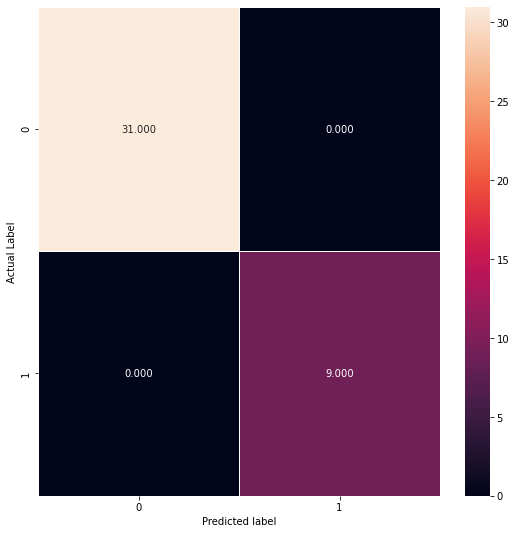

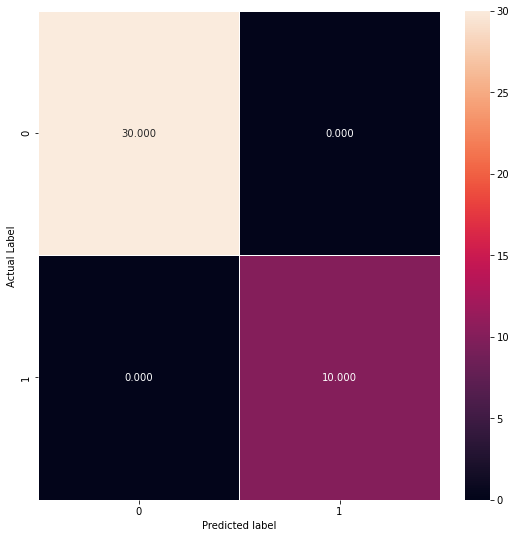

In [32]:
cm = multilabel_confusion_matrix(y_true, y_hat)


for matrix in cm:
    plt.figure(figsize = (9,9))
    sns.heatmap(matrix, annot = True, fmt = ".3f", linewidths=.5, square = False)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted label")

In [ ]:
len(cm)